Florent Giauna (AMSD) et Zewei Lin (MLSD)

Appentissage supervisé pour des données avec classes déséquilibrées

Séance 4: Sur-échantillonage et sous-échantillonage

In [1]:
#Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Pré-traitement
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

#Méthodes d'oversampling et d'undersampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

#Modèles
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Sélection de modèles
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

#Métriques
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Dataset : Credit fraud

In [2]:
#Chargement des données 
df = pd.read_csv('data/creditcard_v2.csv')

#Séparation du dataset en jeux d'entraînement et de test
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=7, shuffle=True, stratify=y)

In [3]:
#Liste des variables
var_list = list(X_train)
    
#Redimensionnement des variables quantitatives
scaler = RobustScaler()

for var in var_list:
    X_train[[var]] = scaler.fit_transform(X_train[[var]])
    X_test[[var]] = scaler.transform(X_test[[var]])

Les variables contenant de nombreux outliers RobustScaler est plus approprié que StandardScaler et MinMaxScaler.

In [4]:
print('Distribution avant oversampling\n', y_train.value_counts())

Distribution avant oversampling
 0    227451
1       394
Name: Class, dtype: int64


Le nombre d'observation étant important aucun modèle de type SVM ne sera utilisé sur les techniques d'oversampling. Les modèles de SVM avec kernel pourront être utilisées après undersampling.

In [11]:
#Algorithmes à utiliser
clfs = {'DecisionTree': DecisionTreeClassifier(random_state=7),
        'LogisiticRegression': LogisticRegression(random_state=7),
        'RandomForest': RandomForestClassifier(random_state=7),
        'XGBoost': XGBClassifier(random_state=7)}

## (a) Pour chaque approche, avec les hyperparamètres par défaut, évaluez la prédiction du churn sur la base de l’AUC (Area Under the Curve). Les pré-traitements qui seront appliqués aux données sont une approche d’oversampling (SMOTE ou ADASYN) et une approche d’undersampling (Random Undersampling ou Tomek Links).

### Oversampling

La technique la plus populaire est la technique Synthetic Minority Oversampling Technique (SMOTE). Des observations proches dans l'espace des caractéristiques sont sélectionnées en traçant une ligne entre les observations et en créant une nouvelle observation comme un point sur cette ligne.

In [12]:
#Oversampling avec SMOTE
sm = SMOTE(random_state=7)
X_res, y_res = sm.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 0    227451
1    227451
Name: Class, dtype: int64


In [13]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.9978962510800127 
PR AUC: 0.9963605011616423 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.9894085691154573 
PR AUC: 0.9907783504198546 

RandomForest 
ROC AUC: 0.9999990599007489 
PR AUC: 0.999998831196991 

XGBoost 
ROC AUC: 0.9999935566197408 
PR AUC: 0.9999925456752233 



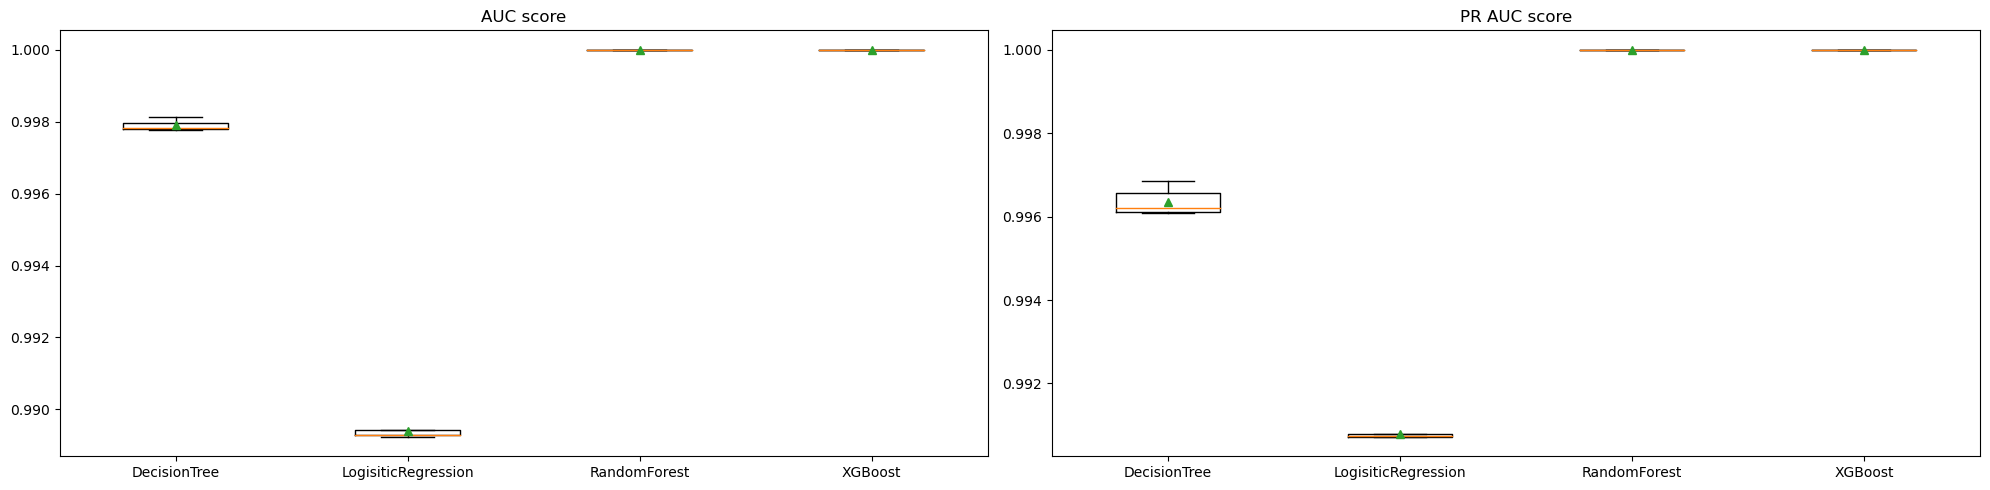

In [14]:
#Comparaison des scores avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Tous les algorithmes performent mieux que sur le jeu déséquilibré et certains sont mêmes supérieurs à ceux obtenus après avoir tuné les hyper-paramètres.

Adaptive Synthetic Sampling (ADASYN) est une extension de SMOTE qui génère des échantillons synthétiques inversement proportionnels à la densité des exemples de la classe minoritaire. Cette technique est conçue pour créer des exemples dans les régions de l'espace des caractéristiques où la densité des exemples minoritaires est faible, et moins ou pas du tout là où la densité est élevée.

In [15]:
#Oversampling avec ADASYN
ada = ADASYN(random_state=7)
X_res, y_res = ada.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 0    227451
1    227440
Name: Class, dtype: int64


In [16]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.9137135623376567 
PR AUC: 0.9125789791116878 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.9516018598848719 
PR AUC: 0.9566737322076607 

RandomForest 
ROC AUC: 0.9965546616641893 
PR AUC: 0.9966973745000942 

XGBoost 
ROC AUC: 0.9989637103015564 
PR AUC: 0.9990698017386912 



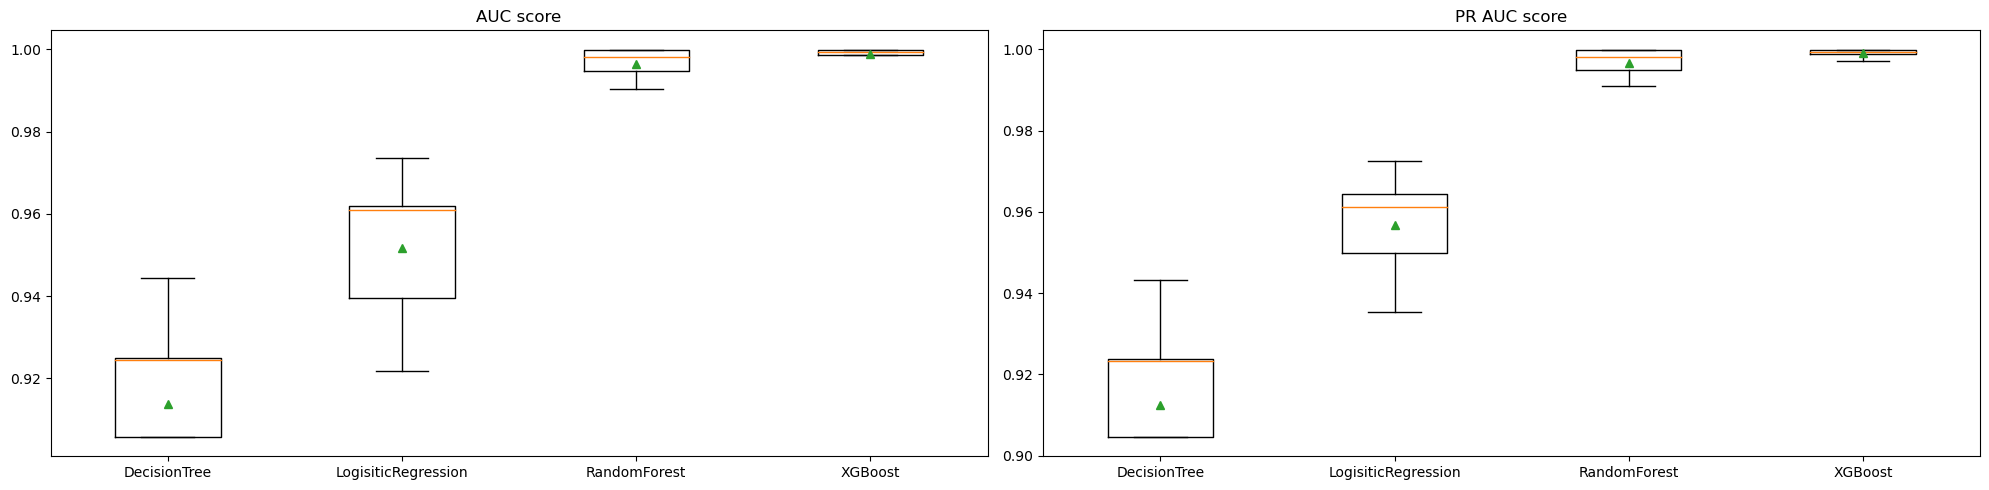

In [17]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Hormis XGBoost tous les résultats sont un peu en dessous de ceux obtenus après SMOTE mais bien meilleurs que ceux obtenus après avoir tuné les hyper-paramètres.

### Undersampling

Une première approche consiste à supprimer aléatoirement des observations de la classe majoritaire dans le jeu d'entraînement.

In [18]:
#Undersampling par Random Undersampling
rus = RandomUnderSampler(random_state=7)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 0    394
1    394
Name: Class, dtype: int64


Le nombre d'observations étant réduit, les méthodes de SVM avec kernel peuvent être essayées.

In [19]:
#Algorithmes à utiliser
clfs = {'DecisionTree': DecisionTreeClassifier(random_state=7),
        'LogisiticRegression': LogisticRegression(random_state=7),
        'SVC (linear)': SVC(kernel='linear', random_state=7),
        'SVC (rbf)': SVC(kernel='rbf', random_state=7),
        'SVC (poly)': SVC(kernel='poly', random_state=7),
        'SVC (sigmoid)': SVC(kernel='sigmoid', random_state=7),
        'RandomForest': RandomForestClassifier(random_state=7),
        'XGBoost': XGBClassifier(random_state=7)}

In [20]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.8997403440441415 
PR AUC: 0.8599788725326889 

LogisiticRegression 
ROC AUC: 0.9771539735167358 
PR AUC: 0.983591078067753 

SVC (linear) 
ROC AUC: 0.978239434015752 
PR AUC: 0.9839377501269728 

SVC (rbf) 
ROC AUC: 0.9797949046627142 
PR AUC: 0.9841131211173023 

SVC (poly) 
ROC AUC: 0.9707389923541182 
PR AUC: 0.9789657253217487 

SVC (sigmoid) 
ROC AUC: 0.9305831166109968 
PR AUC: 0.9560540230189687 

RandomForest 
ROC AUC: 0.9739216266295259 
PR AUC: 0.9797099437702286 

XGBoost 
ROC AUC: 0.9754744267642842 
PR AUC: 0.981457885454455 



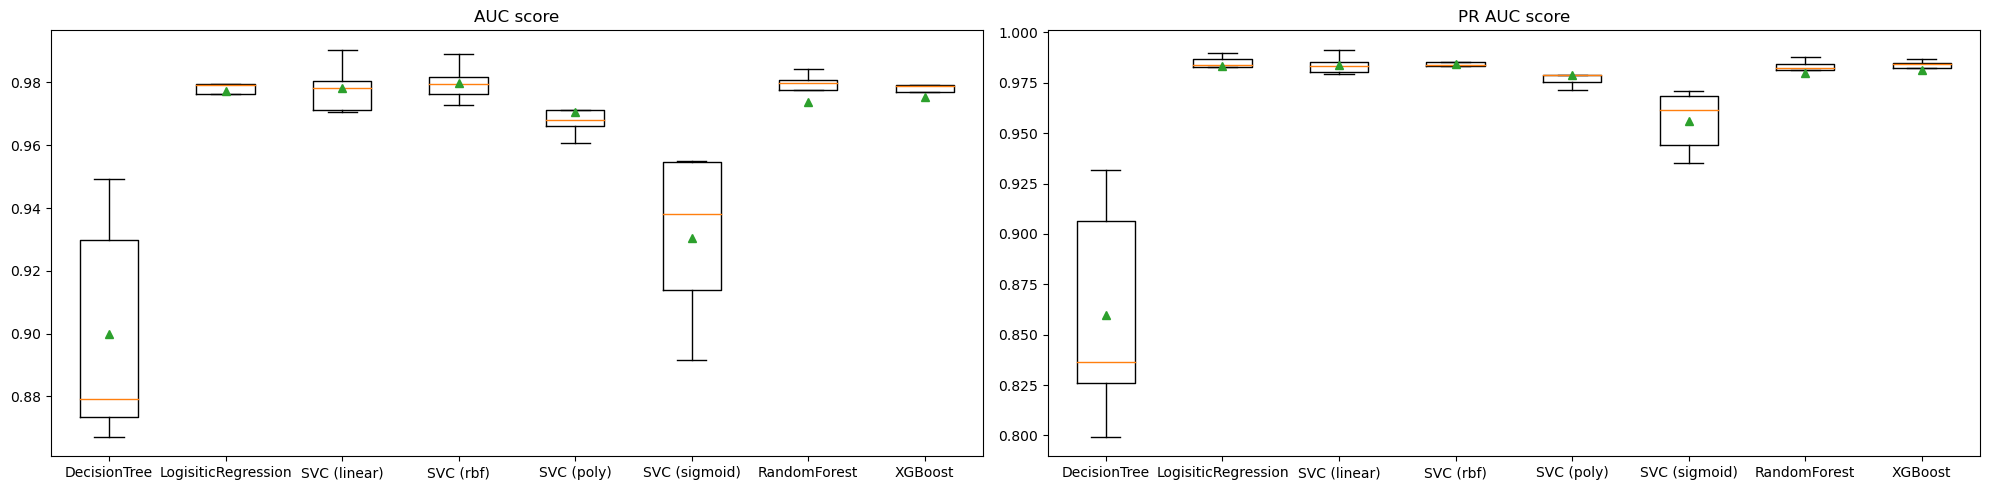

In [21]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Les résultats sont obtenus bien plus rapidement qu'après oversampling. Deux modèles performent moins bien: DecisionTree et SVC avec le kernel sigmoid, ils ont une plus grande variance comme l'indique la représentation en boxplot. Les résultats des autres modèles sont très bons mais le nombre d'observation étant réduit, les modèles auront peut être du mal à généraliser.

Une autre approche est celle dite des Tomek Links. Un lien de Tomek est une paire d'observations qui sont plus proches voisins (ayant la plus petite distance dans l'espace des caractéristiques) et qui appartiennent à des classes différentes. Ce sont souvent des exemples mal classés car à la frontière des classes. Les exemples de la classe majoritaire de chaque paire sont supprimés pour faciliter la classification.

In [22]:
#Undersampling avec Tomek Links
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)

print('Distribution après undersampling\n', y_res.value_counts())

Distribution après undersampling
 0    227428
1       394
Name: Class, dtype: int64


In [23]:
#Algorithmes à utiliser
clfs = {'DecisionTree': DecisionTreeClassifier(random_state=7),
        'LogisiticRegression': LogisticRegression(random_state=7),
        'LinearSVC' : LinearSVC(random_state=7),
        'RandomForest': RandomForestClassifier(random_state=7),
        'XGBoost': XGBClassifier(random_state=7)}

In [24]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.8704588137872277 
PR AUC: 0.566170008670922 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.9760333585940388 
PR AUC: 0.7563171050222737 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

LinearSVC 
ROC AUC: 0.9730187011242816 
PR AUC: 0.7593402246725708 

RandomForest 
ROC AUC: 0.9451185959255497 
PR AUC: 0.8426048200142677 

XGBoost 
ROC AUC: 0.9787652517664703 
PR AUC: 0.8543665499805236 



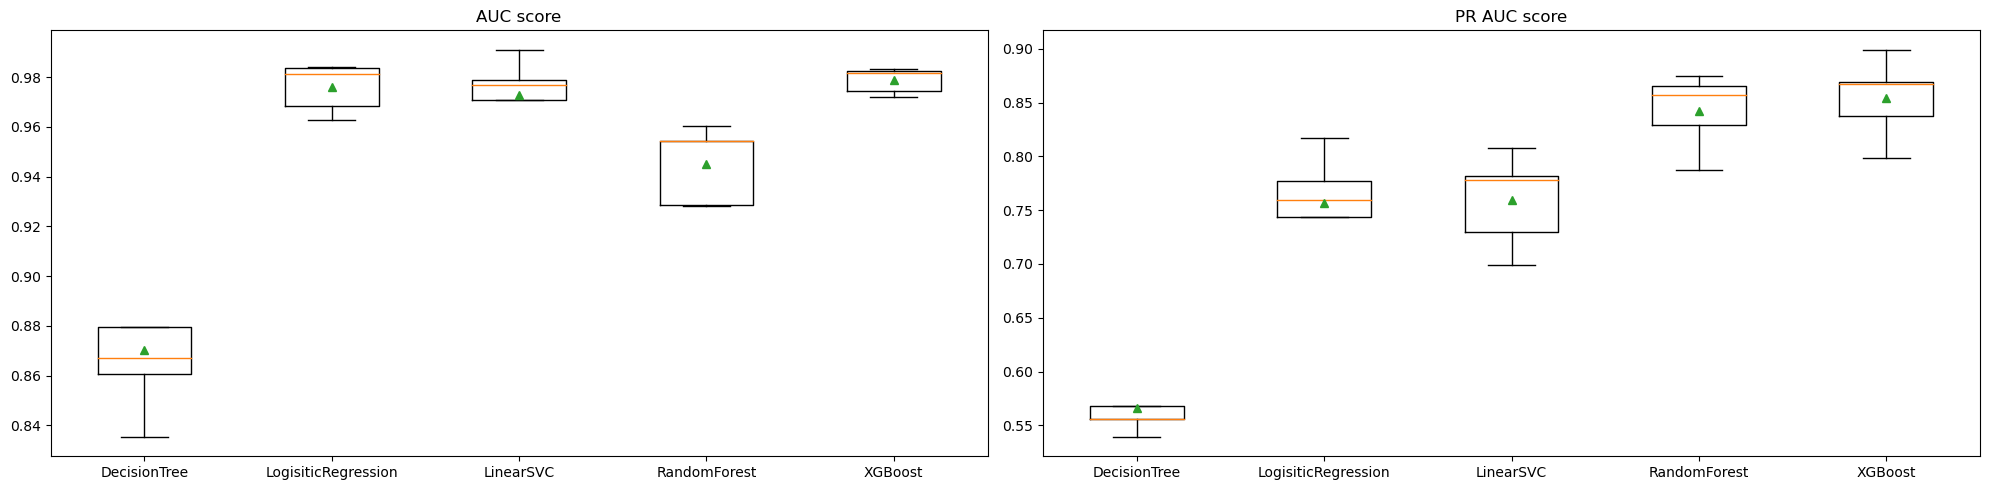

In [25]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Le jeu étant déséquilibré après resampling, le PR AUC est un meilleur indicateur des résultats. Les résultats sont moins bons qu'après le random undersampling.

Globalement les résultats après undersampling sont un peu moins bons que ceux obtenus après oversampling et ont également une plus grande variance. Mais les résultats restent très bons : les écarts sont de l'ordre d'un centième alors qu'ils sont obtenus beaucoup plus rapidement en raison 

## (b) Pour chaque approche, définissez un modèle performant en recherchant de bons hyper-paramètres via un grid search. Comparer les meilleurs modèles pour chaque approche sur la base de l’AUC (Area Under the Curve).

Les ressources de calcul à notre disposition étant limité, le temps d'exécution des modèles après oversampling est trop long sur ce jeu de donnée. Un grid search sera donc effectué seulement pour les approches d'undersampling.

#### Undersampling par Random Undersampling

In [30]:
#Undersampling par Random Undersampling
rus = RandomUnderSampler(random_state=7)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [32]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [1,3,5,7,9,15,25,30],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 3, 'random_state': 7} 
ROC AUC: 0.9514823396973695


In [33]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[0.01, 0.1, 1],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

Meilleure configuration: {'C': 0.1, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.9797188977769015


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_select

Le nombre d'observations étant réduit, les méthodes de SVM avec kernel peuvent être essayées.

In [35]:
#Instanciation du modèle SVC avec kernel
clf_svc = SVC()

#Création de la grille de paramètres à tester
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
              'kernel': ['rbf', 'poly'],
              'gamma': ['scale', 'auto', 1, 10, 100],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 7} 
ROC AUC: 0.9811909662734852


In [41]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [50, 100, 200],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5,7,9,15,30],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 200, 'random_state': 7} \ROC AUC: 0.9763877419381345


In [44]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.1, 0.3],
              'max_depth': [5,7,9,10,12,15,30],
              'n_estimators': [25,50,100,200],
              'reg_alpha': [0.001,0.01],
              'reg_lambda': [0.001,0.01],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 25, 'random_state': 7, 'reg_alpha': 0.001, 'reg_lambda': 0.01} 
ROC AUC: 0.9771987559521609


Les modèles les plus prometteurs sont dans l'ordre SVC avec le kernel rbf, LogisticRegression et XGBoost. Tous 3 sont peu complexes et obtiennent des résultats élevés dans un temps très court.

#### Undersampling avec Tomek Links

In [5]:
#Undersampling avec Tomek Links
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)

In [47]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [3,5,7,30],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 5, 'random_state': 7} 
ROC AUC: 0.9119739499145817


In [7]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[0.001, 0.01, 0.1],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

Meilleure configuration: {'C': 0.01, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.9800422442616787


In [15]:
#Instanciation du modèle SVC sans kernel
clf_svc = LinearSVC()

#Création de la grille de paramètres à tester
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'loss': ['hinge', 'squared_hinge'],
              'C': [0.1, 1, 10],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='average_precision',
                    return_train_score=True,
                    cv=5)

grid.fit(X_train, y_train)

print("Meilleure configuration:", grid.best_params_, 
      "\nAverage precision (PR AUC):", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

Meilleure configuration: {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 7} 
Average precision (PR AUC): 0.7157001813949233


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [50],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5,7,10],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 50, 'random_state': 7} \ROC AUC: 0.9770124697575804


In [14]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [5,10,15],
              'n_estimators': [25, 50],
              'reg_alpha': [0.001,0.01],
              'reg_lambda': [0.001,0.01],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 50, 'random_state': 7, 'reg_alpha': 0.001, 'reg_lambda': 0.001} 
ROC AUC: 0.9729819751917164


Les résultats de la régression logistique et des modèles ensemblistes sont un légèrement meilleurs mais sont très longs à obtenir.

### Meilleure approche et meilleur modèle

Nous avons retenus trois modèles, à la suite de la même approche de resampling, ayant eu des résultats équivalents et étant peu complexes. Nous pouvons donc nous permettre d'évaluer les trois sur notre jeu test afin de les comparer.

In [49]:
#Undersampling par Random Undersampling
rus = RandomUnderSampler(random_state=7)
X_res, y_res = rus.fit_resample(X_train, y_train)

#Instanciation du meilleur modèle
clf = SVC(C=10,
          kernel='rbf',
          gamma='scale',
          random_state=7)

clf.fit(X_res, y_res)

#Classification du jeu test
pred = cross_val_predict(clf, X_test, y_test, cv=5)

#Résultats
clf_results = cross_validate(clf, X_test, y_test, scoring='roc_auc', cv=5)
print("\nROC AUC:", clf_results['test_score'].mean())


ROC AUC: 0.9621671278024359


In [50]:
#Matrice de confusion
print(confusion_matrix(y_test, pred))

[[56859     5]
 [   49    49]]


In [51]:
#Rapport de classification
print(classification_report(y_test, pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.50      0.64        98

    accuracy                           1.00     56962
   macro avg       0.95      0.75      0.82     56962
weighted avg       1.00      1.00      1.00     56962



In [61]:
#Instanciation du deuxième meilleur modèle
clf = LogisticRegression(C=0.1,
                         solver='lbfgs',
                         penalty='l2',
                         random_state=7)

clf.fit(X_res, y_res)

#Classification du jeu test
pred = cross_val_predict(clf, X_test, y_test, cv=5)

#Résultats
clf_results = cross_validate(clf, X_test, y_test, scoring='roc_auc', cv=5)
print("\nROC AUC:", clf_results['test_score'].mean())


ROC AUC: 0.9729363679485925


In [62]:
#Matrice de confusion
print(confusion_matrix(y_test, pred))

[[56858     6]
 [   37    61]]


In [54]:
#Rapport de classification
print(classification_report(y_test, pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.62      0.74        98

    accuracy                           1.00     56962
   macro avg       0.95      0.81      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [55]:
#Instanciation du troisième meilleur modèle
clf = XGBClassifier(learning_rate=0.3,
                    max_depth=10,
                    n_estimators=25,
                    reg_alpha=0.001, 
                    reg_lambda=0.01,
                    random_state=7)

clf.fit(X_res, y_res)

#Classification du jeu test
pred = cross_val_predict(clf, X_test, y_test, cv=5)

#Résultats
clf_results = cross_validate(clf, X_test, y_test, scoring='roc_auc', cv=5)
print("\nROC AUC:", clf_results['test_score'].mean()) 


ROC AUC: 0.9704182062431599


In [56]:
#Matrice de confusion
print(confusion_matrix(y_test, pred))

[[56854    10]
 [   19    79]]


In [57]:
#Rapport de classification
print(classification_report(y_test, pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.81      0.84        98

    accuracy                           1.00     56962
   macro avg       0.94      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



Cette dernière combinaison de sampling et de modèle donne les meilleurs résultats obtenus jusqu'à présent sur ce jeu de données. Toutes les métriques sont au dessus du meilleur modèle jusqu'à présent, un autre XGBoost par ailleurs plus complexe.

Ce modèle est plus long que la régression linéaire mais l'écart (15 secondes contre 1 seconde) n'est pas rédhibitoire pour notre capacité de calcul. Il peut donc être choisi pour passer en production.

# Dataset : Bank marketing

In [2]:
#Chargement des données 
df = pd.read_csv('data/bank-additional-full_v2.csv')

In [3]:
#Séparation du dataset en jeux d'entraînement et de test
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=7, shuffle=True, stratify=y.to_numpy())

In [4]:
#Liste des variables catégorielles nominales
var_nom = list(X_train.select_dtypes(['object']).columns)
var_nom += ['age', 'duration', 'pdays']

#Liste des variables quantitatives
var_quant = ['campaign', 'cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 
             'euribor3m', 'nr.employed', 'previous']

In [5]:
#Encodage des variables nominales 
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

for var in var_nom:
    ohe_train = ohe.fit_transform(X_train[[var]])
    X_train = pd.concat([X_train, ohe_train],axis=1).drop(columns=[var])
    ohe_test = ohe.transform(X_test[[var]])
    X_test = pd.concat([X_test, ohe_test],axis=1).drop(columns=[var])

In [6]:
#Redimensionnement des variables quantitatives
scaler = RobustScaler()

for var in var_quant:
    X_train[[var]] = scaler.fit_transform(X_train[[var]])
    X_test[[var]] = scaler.transform(X_test[[var]])

Les variables n'ayant pas de distribution gaussienne et le jeu de données contenant de nombreux outliers RobustScaler est plus approprié que StandardScaler et MinMaxScaler.

In [8]:
print('Distribution avant oversampling\n', y_train.value_counts())

Distribution avant oversampling
 0    29238
1     3712
Name: y, dtype: int64


In [7]:
#Algorithmes à utiliser
clfs = {'DecisionTree': DecisionTreeClassifier(random_state=7),
        'LogisiticRegression': LogisticRegression(random_state=7),
        'LinearSVC': LinearSVC(random_state=7),
        'RandomForest': RandomForestClassifier(random_state=7),
        'XGBoost': XGBClassifier(random_state=7)}

Le nombre d'observation étant important seul LinearSVC sera utilisé sur les techniques d'oversampling. Les modèles de SVM avec kernel pourront être utilisées après undersampling.

## (a) Pour chaque approche, avec les hyperparamètres par défaut, évaluez la prédiction du churn sur la base de l’AUC (Area Under the Curve). Les pré-traitements qui seront appliqués aux données sont une approche d’oversampling (SMOTE ou ADASYN) et une approche d’undersampling (Random Undersampling ou Tomek Links).

### Oversampling

La technique la plus populaire est la technique Synthetic Minority Oversampling Technique (SMOTE). Des observations proches dans l'espace des caractéristiques sont sélectionnées en traçant une ligne entre les observations et en créant une nouvelle observation comme un point sur cette ligne.

In [72]:
#Oversampling avec SMOTE
sm = SMOTE(random_state=7)
X_res, y_res = sm.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 0    29238
1    29238
Name: y, dtype: int64


In [73]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.9239783560565236 
PR AUC: 0.8904789245579277 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.9200926355758471 
PR AUC: 0.8977412136964433 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

LinearSVC 
ROC AUC: 0.9190454003856461 
PR AUC: 0.8962360559861248 

RandomForest 
ROC AUC: 0.9942789199957858 
PR AUC: 0.9935335386019861 

XGBoost 
ROC AUC: 0.9890170538688391 
PR AUC: 0.988780080289208 



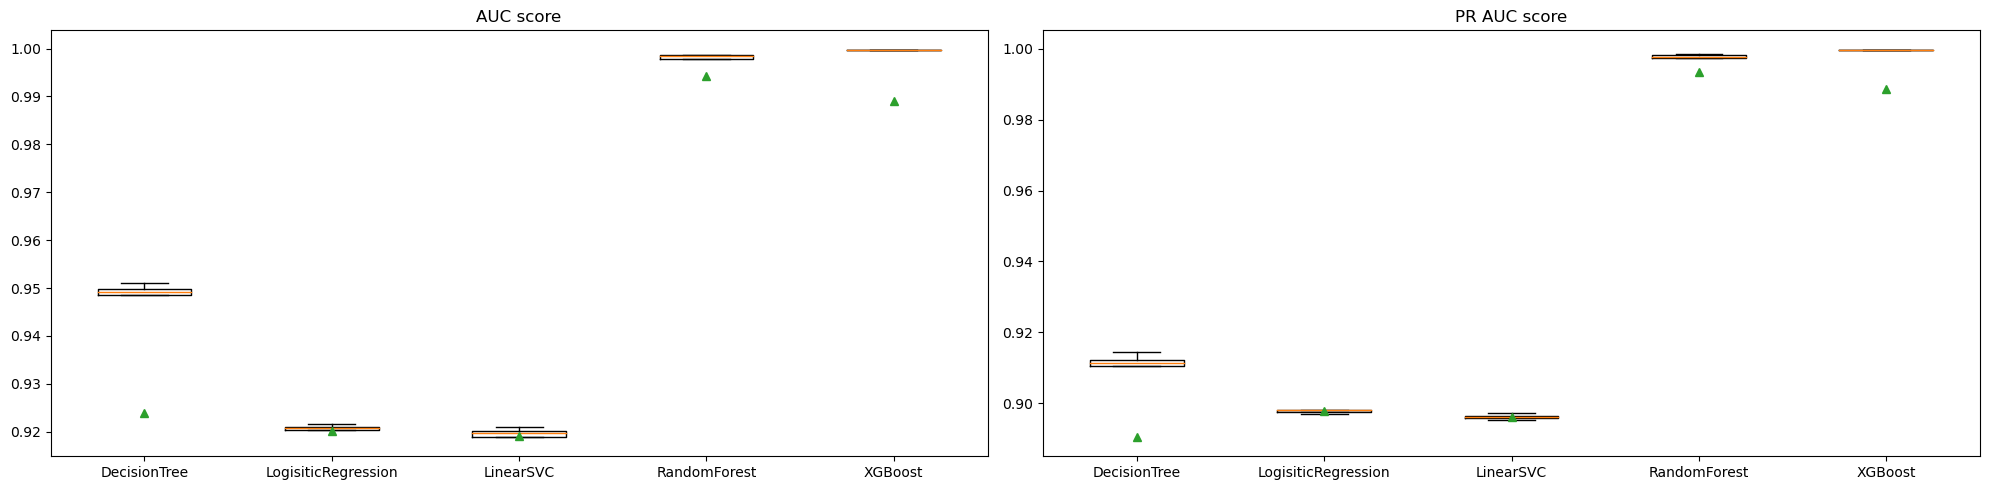

In [76]:
#Comparaison des scores avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Tous les modèles performent beaucoup mieux que sur le jeu déséquilibré et sont mêmes supérieurs à ceux obtenus après avoir tuné les hyper-paramètres.

Adaptive Synthetic Sampling (ADASYN) est une extension de SMOTE qui génère des échantillons synthétiques inversement proportionnels à la densité des exemples de la classe minoritaire. Cette technique est conçue pour créer des exemples dans les régions de l'espace des caractéristiques où la densité des exemples minoritaires est faible, et moins ou pas du tout là où la densité est élevée.

In [77]:
#Oversampling avec ADASYN
ada = ADASYN(random_state=7)
X_res, y_res = ada.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 0    29238
1    28877
Name: y, dtype: int64


In [78]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.9115807545257557 
PR AUC: 0.8769039381942363 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.9017310675576482 
PR AUC: 0.8625519623644042 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

LinearSVC 
ROC AUC: 0.9002901144593096 
PR AUC: 0.8608140347486636 

RandomForest 
ROC AUC: 0.9928894978872009 
PR AUC: 0.9912714629068426 

XGBoost 
ROC AUC: 0.9880030915270053 
PR AUC: 0.987300614068954 



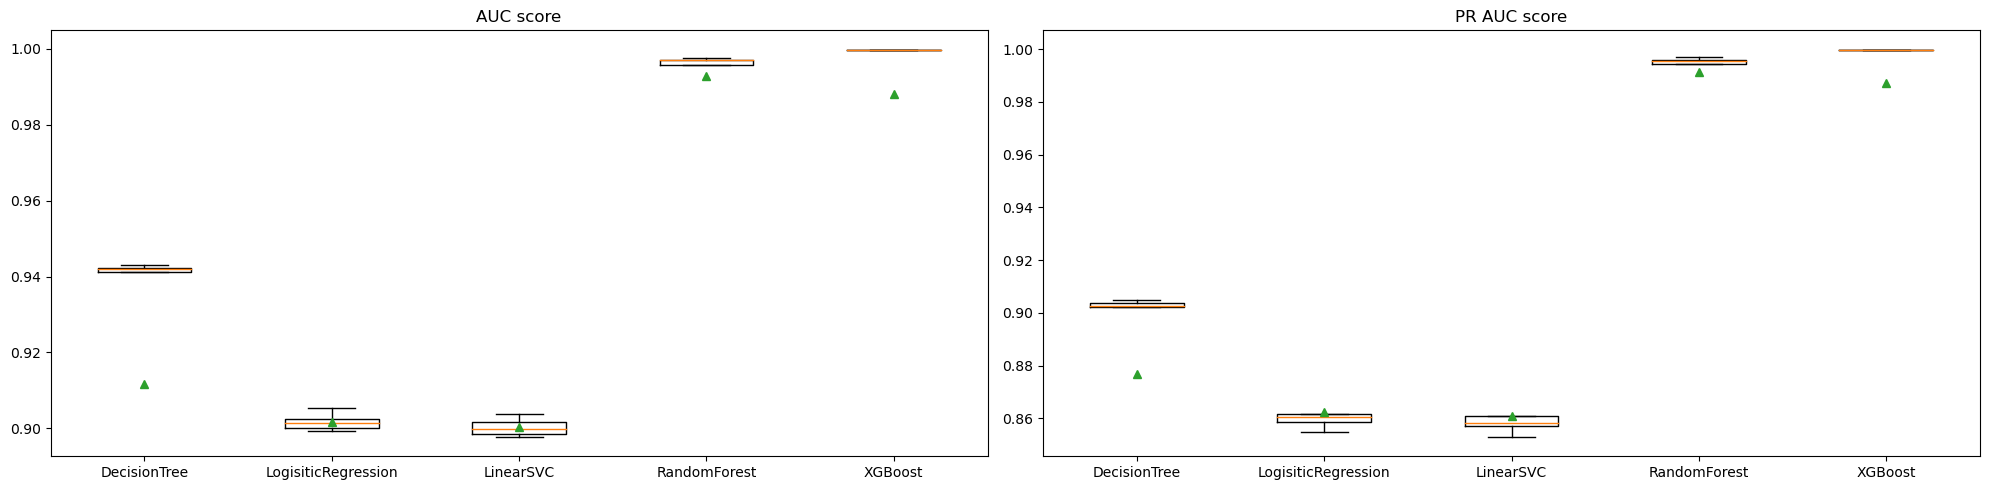

In [79]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Hormis DecisionTree tous les résultats sont un peu en dessous de ceux obtenus après SMOTE mais bien meilleurs que ceux obtenus après avoir tuné les hyper-paramètres.

### Undersampling

Une première approche consiste à supprimer aléatoirement des observations de la classe majoritaire dans le jeu d'entraînement.

In [80]:
#Undersampling par Random Undersampling
rus = RandomUnderSampler(random_state=7)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 0    3712
1    3712
Name: y, dtype: int64


Les observations étant moins nombreuses, les modèles de SVM avec kernel peuvent être utilisés.

In [81]:
clfs = {'DecisionTree': DecisionTreeClassifier(random_state=7),
        'LogisiticRegression': LogisticRegression(random_state=7),
        'SVC (linear)': SVC(kernel='linear', random_state=7),
        'SVC (rbf)': SVC(kernel='rbf', random_state=7),
        'SVC (poly)': SVC(kernel='poly', random_state=7),
        'SVC (sigmoid)': SVC(kernel='sigmoid', random_state=7),
        'RandomForest': RandomForestClassifier(random_state=7),
        'XGBoost': XGBClassifier(random_state=7)}

In [82]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.7865766650565391 
PR AUC: 0.7273821513385063 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.9076971039109554 
PR AUC: 0.8822805307475365 

SVC (linear) 
ROC AUC: 0.8985801883638951 
PR AUC: 0.8698968749472746 

SVC (rbf) 
ROC AUC: 0.904928467675917 
PR AUC: 0.8782680938079629 

SVC (poly) 
ROC AUC: 0.9032707812860895 
PR AUC: 0.8768526256873372 

SVC (sigmoid) 
ROC AUC: 0.7973641007680043 
PR AUC: 0.7365328183187323 

RandomForest 
ROC AUC: 0.9068892178135245 
PR AUC: 0.8765658977400459 

XGBoost 
ROC AUC: 0.9097344748534045 
PR AUC: 0.8842352859053857 



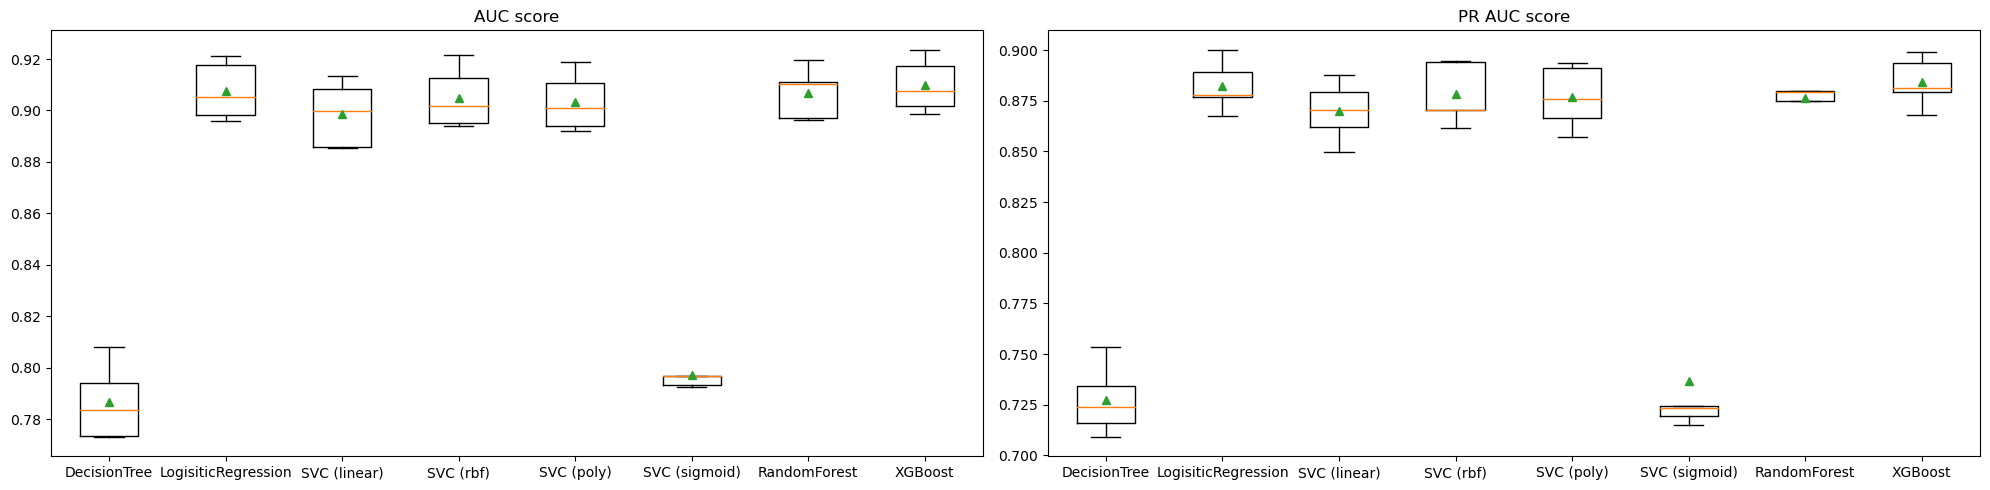

In [84]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Les résultats sont un peu en dessous de ceux obtenus après oversampling et ont également une plus grande variance comme l'indique la représentation en boxplot. Toutefois ces résultats restent meilleurs que ceux obtenus après avoir tuné les hyper-paramètres. Hormis DecisionTree et SVC (sigmoid) tous les modèles semblent être de bons candidats.

Une autre approche est celle dite des Tomek Links. Un lien de Tomek est une paire d'observations qui sont plus proches voisins (ayant la plus petite distance dans l'espace des caractéristiques) et qui appartiennent à des classes différentes. Ce sont souvent des exemples mal classés car à la frontière des classes. Les exemples de la classe majoritaire de chaque paire sont supprimés pour faciliter la classification.

In [85]:
#Undersampling avec Tomek Links
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)

print('Distribution après undersampling\n', y_res.value_counts())

Distribution après undersampling
 0    28397
1     3712
Name: y, dtype: int64


In [86]:
#Algorithmes à utiliser
clfs = {'DecisionTree': DecisionTreeClassifier(random_state=7),
        'LogisiticRegression': LogisticRegression(random_state=7),
        'LinearSVC': LinearSVC(random_state=7),
        'RandomForest': RandomForestClassifier(random_state=7),
        'XGBoost': XGBClassifier(random_state=7)}

In [87]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.7145602284502404 
PR AUC: 0.295913841156682 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.9205365008822847 
PR AUC: 0.6009255220623633 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

LinearSVC 
ROC AUC: 0.9208888086945114 
PR AUC: 0.6087265320923875 

RandomForest 
ROC AUC: 0.9266872438120638 
PR AUC: 0.6275109676965008 

XGBoost 
ROC AUC: 0.9286282418497006 
PR AUC: 0.6287524765749234 



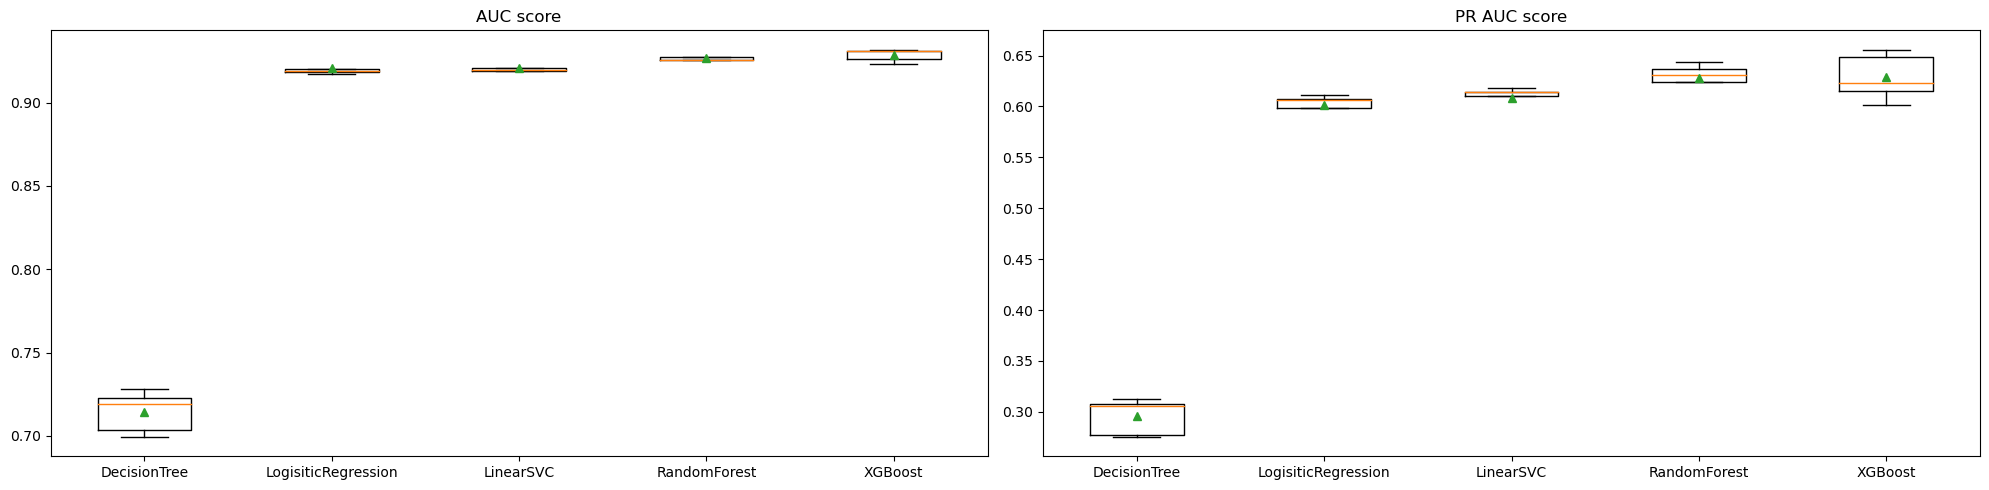

In [88]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Le jeu étant déséquilibré après resampling, le PR AUC est un meilleur indicateur des résultats. Hormis DecisionTree les modèles performent mieux que les modèles dont les hyper-paramètres ont été tunés mais ces résultats sont moins bons que ceux obtenus après random undersampling.

Globalement les résultats sont moins bons que ceux obtenus après oversampling et ont également une plus grande variance. Certains résultats ne sont pas au dessus de ceux obtenus après avoir tuné les hyper-paramètres. 
Entre toutes les techniques, les résultats les plus prometteurs sont ceux obtenus par RandomForest et XGBoost avec oversampling.

## (b) Pour chaque approche, définissez un modèle performant en recherchant de bons hyper-paramètres via un gird search. Comparer les meilleurs modèles pour chaque approche sur la base de l’AUC (Area Under the Curve).

### Oversampling

#### Oversampling avec SMOTE

In [9]:
#Oversampling avec SMOTE
sm = SMOTE(random_state=7)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [95]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [1,5,10,15,25,50,70],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'gini', 'max_depth': 10, 'random_state': 7} 
ROC AUC: 0.9559199554113593


In [96]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[1e5, 1e6, 1e7],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

Meilleure configuration: {'C': 10000000.0, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.9201851548269859


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
#Instanciation du modèle SVC sans kernel
clf_svc = LinearSVC()

#Création de la grille de paramètres à tester
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'loss': ['hinge', 'squared_hinge'],
              'C': [0.1, 1, 10],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

Meilleure configuration: {'C': 1, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 7} 
ROC AUC: 0.9190454003856461


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [15,45,50,55,70],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100, 'random_state': 7} \ROC AUC: 0.9945788105439461


In [13]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [30,40,50,70],
              'n_estimators': [50],
              'reg_alpha': [0.01,0.1],
              'reg_lambda': [0.01,0.1],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 50, 'n_estimators': 50, 'random_state': 7, 'reg_alpha': 0.01, 'reg_lambda': 0.01} 
ROC AUC: 0.9934605477502089


#### Oversampling avec ADASYN

In [14]:
#Oversampling avec ADASYN
ada = ADASYN(random_state=7)
X_res, y_res = ada.fit_resample(X_train, y_train)

In [16]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [1,5,10,15,20,25,50,70],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 15, 'random_state': 7} 
ROC AUC: 0.9518012160096425


In [17]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[1e5, 1e6, 1e7],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

Meilleure configuration: {'C': 10000000.0, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.9018771282727609


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
#Instanciation du modèle SVC sans kernel
clf_svc = LinearSVC()

#Création de la grille de paramètres à tester
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'loss': ['hinge', 'squared_hinge'],
              'C': [0.1, 1, 10],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

Meilleure configuration: {'C': 1, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 7} 
ROC AUC: 0.9002901144593096


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [21]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [25,30,35,70],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100, 'random_state': 7} \ROC AUC: 0.9937140747108859


In [24]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [40,50,70],
              'n_estimators': [50],
              'reg_alpha': [0.01,0.1],
              'reg_lambda': [0.01,0.1],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 70, 'n_estimators': 50, 'random_state': 7, 'reg_alpha': 0.01, 'reg_lambda': 0.1} 
ROC AUC: 0.9927638979586426


DecisionTree performe moins bien qu'après SMOTE et est plus complexe (profondeur de 15 au lieu de 10).

LogisticRegression performe moins bien pour la même complexité.

SVC performe moins bien pour la même complexité.

RandomForest performe quasiment pareil mais est moins complexe (profondeur de 30 au lieu de 50).

XGBoost performe quasiment pareil mais est plus complexe (profondeur de 70 au lieu de 50).

### Undersampling

#### Undersampling par Random Undersampling

In [25]:
#Undersampling par Random Undersampling
rus = RandomUnderSampler(random_state=7)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [106]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [1,3,5,7,15,25,50,70],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 5, 'random_state': 7} 
ROC AUC: 0.9021063573393961


In [111]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[1e4, 1e5, 1e6],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

Meilleure configuration: {'C': 100000.0, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.9079609517857147


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logist

La complexité de calcul étant importante avec les SVM seul les kernels qui semblaient les plus prometteurs avec RandomUndersampling sont utilisés, le kernel sigmoid est donc retiré.

In [31]:
#Instanciation du modèle SVC avec kernel
clf_svc = SVC()

#Création de la grille de paramètres à tester
param_grid = {'C': [0.01, 0.1, 1], 
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'random_state': 7} 
ROC AUC: 0.906863752186269


In [34]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [50,100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5,10,15,20,30,70],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100, 'random_state': 7} \ROC AUC: 0.9163010781856947


In [36]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [1,3,5,7,15],
              'n_estimators': [50,100],
              'reg_alpha': [0.01,0.1],
              'reg_lambda': [0.01,0.1],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'random_state': 7, 'reg_alpha': 0.1, 'reg_lambda': 0.1} 
ROC AUC: 0.9188500021262914


Les résultats sont moins bons (de l'ordre de 0.08 pour les modèles ensemblistes) mais les modèles sont moins complexes qu'après oversampling et les résultats sont obtenus plus rapidement en raison du plus petit nombre d'observations. Le modèle XGBoost après random undersampling est un bon candidat au vu de sa faible complexité.

#### Undersampling avec Tomek Links

In [116]:
#Undersampling avec Tomek Links
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)

In [117]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [1,5,7,9,15,25,50,70],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 5, 'random_state': 7} 
ROC AUC: 0.9192913789777425


In [119]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[1000, 1e4, 1e5],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

Meilleure configuration: {'C': 10000.0, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.920710701947556


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La complexité de calcul étant importante avec les SVM seul les kernels rbf et poly, qui semblaient les plus prometteurs avec SMOTE, sont utilisés.

In [120]:
#Instanciation du modèle SVC sans kernel
clf_svc = LinearSVC()

#Création de la grille de paramètres à tester
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'loss': ['hinge', 'squared_hinge'],
              'C': [0.1, 1, 10],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

Meilleure configuration: {'C': 1, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 7} 
ROC AUC: 0.9208888086945114


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [122]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5,10,15,20,25],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100, 'random_state': 7} \ROC AUC: 0.931328306460534


In [123]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [1,3,5,15,30],
              'n_estimators': [100],
              'reg_alpha': [0.01,0.1],
              'reg_lambda': [0.01,0.1],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'random_state': 7, 'reg_alpha': 0.1, 'reg_lambda': 0.1} 
ROC AUC: 0.9309314527741874


Les résultats sont moins bons qu'après les techniques d'oversampling mais les modèles sont moins complexes. Le dernier modèle XGBoost semble être le meilleur compromis entre résultat et complexité.

### Meilleure approche et meilleur modèle

In [47]:
#Undersampling avec Tomek Links
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)

#Instanciation du meilleur modèle
clf = XGBClassifier(learning_rate=0.3,
                    max_depth=3, 
                    n_estimators=100,
                    random_state=7,
                    reg_alpha=0.1,
                    reg_lambda=0.1)

clf.fit(X_res, y_res)

#Classification du jeu test
pred = cross_val_predict(clf, X_test, y_test, cv=5)

#Résultats
clf_results = cross_validate(clf, X_test, y_test, scoring='roc_auc', cv=5)
print("\nROC AUC:", clf_results['test_score'].mean())


ROC AUC: 0.9158604058804845


In [48]:
#Matrice de confusion
print(confusion_matrix(y_test, pred))

[[7109  201]
 [ 579  349]]


In [49]:
#Rapport de classification
print(classification_report(y_test, pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7310
           1       0.63      0.38      0.47       928

    accuracy                           0.91      8238
   macro avg       0.78      0.67      0.71      8238
weighted avg       0.89      0.91      0.89      8238



Cette combinaison de sampling et de modèle ne donne pas de résultats nettement meilleurs que ceux obtenus à la séance 3 par notre modèle RandomForest sans resampling. Il y a moins de faux négatifs mais plus de faux positifs. Le F1 score sur la classe majoritaire est meilleur mais celui sur la classe minoritaire a baissé (0.47 contre 0.53). La classe minoritaire est moins bien prédite.

Le modèle RandomForest sans resampling devrait être privilégié. Le risque est de passer à côté de potentiels souscripteurs et de consacrer trop de temps de la campagne à des clients qui ont plus de chance de ne pas souscrire.

# Dataset : Employee attrition

In [2]:
#Chargement des données 
df = pd.read_csv('data/whole_data_v2.csv')

In [3]:
#Liste des variables quantitatives
var_quant = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 
            'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 
            'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

#Liste des variables qualitatives
var_cat = ['JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction',
           'WorkLifeBalance', 'BusinessTravel', 'Department', 'Education', 
           'EducationField', 'Gender', 'MaritalStatus', 'JobLevel', 'JobRole', 'StockOptionLevel']

#Liste des variables qualitatives ordinales
var_ord = ['JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction',
           'WorkLifeBalance', 'BusinessTravel', 'JobLevel', 'StockOptionLevel']

#Liste des variables qualitatives nominales
var_nom = ['Department', 'Education', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

In [4]:
#Séparation du dataset en jeux d'entraînement et de test
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=7, shuffle=True, stratify=y.to_numpy())

In [5]:
#Encodage des variables nominales 
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

for var in var_nom:
    ohe_train = ohe.fit_transform(X_train[[var]])
    X_train = pd.concat([X_train, ohe_train],axis=1).drop(columns=[var])
    ohe_test = ohe.transform(X_test[[var]])
    X_test = pd.concat([X_test, ohe_test],axis=1).drop(columns=[var])

#Encodage des variables ordinales
encoder = OrdinalEncoder(categories=[[0,1,2,3,4,5]], 
                         handle_unknown='use_encoded_value',
                         unknown_value=99)

for var in var_ord:
    X_train[[var]] = encoder.fit_transform(X_train[[var]])
    X_test[[var]] = encoder.transform(X_test[[var]])

In [6]:
#Redimensionnement des variables quantitatives
scaler = RobustScaler()

for var in var_quant:
    X_train[[var]] = scaler.fit_transform(X_train[[var]])
    X_test[[var]] = scaler.transform(X_test[[var]])

In [7]:
#Algorithmes à utiliser
clfs = {'DecisionTree': DecisionTreeClassifier(random_state=7),
        'LogisiticRegression': LogisticRegression(random_state=7),
        'SVC (linear)': SVC(kernel='linear', random_state=7),
        'SVC (rbf)': SVC(kernel='rbf', random_state=7),
        'SVC (poly)': SVC(kernel='poly', random_state=7),
        'SVC (sigmoid)': SVC(kernel='sigmoid', random_state=7),
        'RandomForest': RandomForestClassifier(random_state=7),
        'XGBoost': XGBClassifier(random_state=7)}

In [8]:
print('Distribution avant oversampling\n', y_train.value_counts())

Distribution avant oversampling
 0    2941
1     564
Name: Attrition, dtype: int64


## (a) Pour chaque approche, avec les hyperparamètres par défaut, évaluez la prédiction du churn sur la base de l’AUC (Area Under the Curve). Les pré-traitements qui seront appliqués aux données sont une approche d’oversampling (SMOTE ou ADASYN) et une approche d’undersampling (Random Undersampling ou Tomek Links).

### Oversampling

La technique la plus populaire est la technique Synthetic Minority Oversampling Technique (SMOTE). Des observations proches dans l'espace des caractéristiques sont sélectionnées en traçant une ligne entre les observations et en créant une nouvelle observation comme un point sur cette ligne.

In [9]:
#Oversampling avec SMOTE
sm = SMOTE(random_state=7)
X_res, y_res = sm.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 0    2941
1    2941
Name: Attrition, dtype: int64


In [10]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.9792568980053822 
PR AUC: 0.9714011860351119 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.7761036193810649 
PR AUC: 0.7517816760351363 

SVC (linear) 
ROC AUC: 0.7764573939944064 
PR AUC: 0.746912501852077 

SVC (rbf) 
ROC AUC: 0.8225661305604209 
PR AUC: 0.8173154596031369 

SVC (poly) 
ROC AUC: 0.7908942618545172 
PR AUC: 0.7881903310270466 

SVC (sigmoid) 
ROC AUC: 0.695292046458351 
PR AUC: 0.6920167285947232 

RandomForest 
ROC AUC: 0.9995764170214244 
PR AUC: 0.999629031592774 

XGBoost 
ROC AUC: 0.9975994024765352 
PR AUC: 0.9983015711306322 



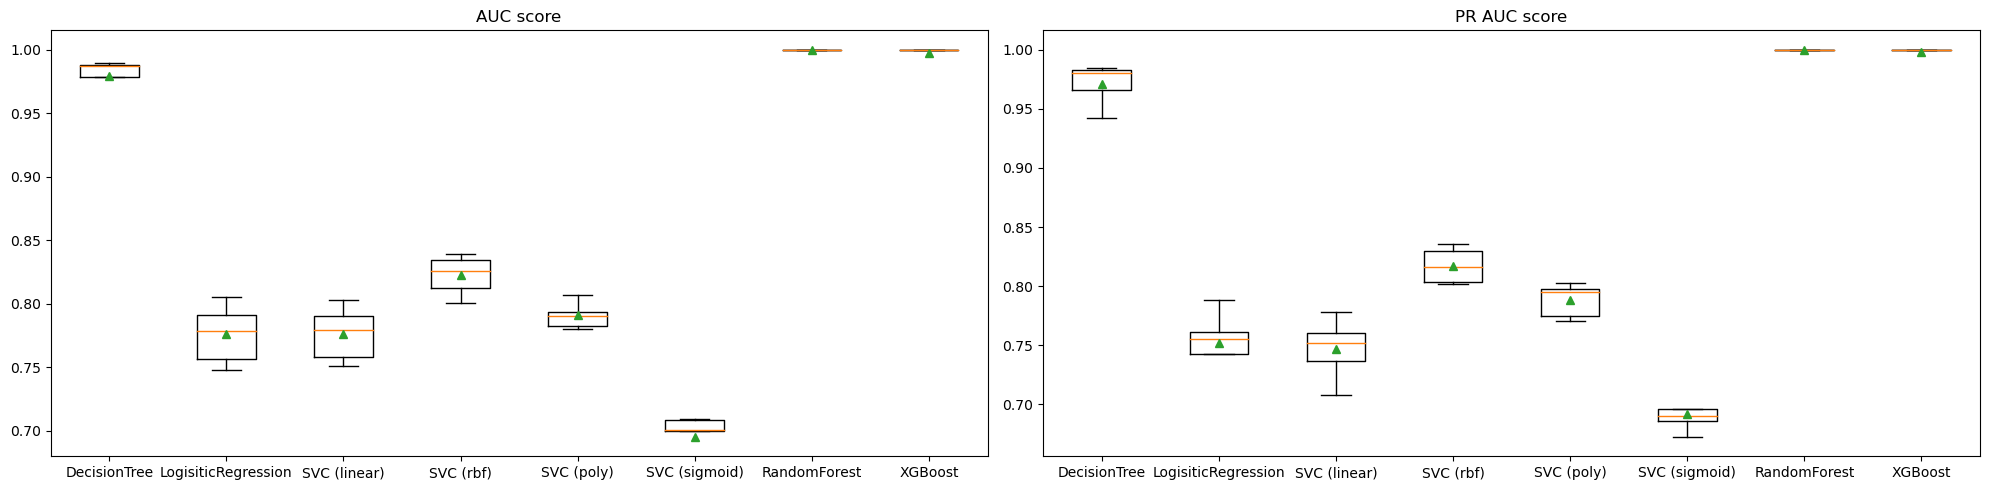

In [11]:
#Comparaison des scores avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Tous les algorithmes performent mieux que sur le jeu déséquilibré et certains sont mêmes supérieurs à ceux obtenus après avoir tuné les hyper-paramètres.

Adaptive Synthetic Sampling (ADASYN) est une extension de SMOTE qui génère des échantillons synthétiques inversement proportionnels à la densité des exemples de la classe minoritaire. Cette technique est conçue pour créer des exemples dans les régions de l'espace des caractéristiques où la densité des exemples minoritaires est faible, et moins ou pas du tout là où la densité est élevée.

In [12]:
#Oversampling avec ADASYN
ada = ADASYN(random_state=7)
X_res, y_res = ada.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 1    2984
0    2941
Name: Attrition, dtype: int64


In [13]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.9695330647916842 
PR AUC: 0.9614871384208277 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.7444410733960307 
PR AUC: 0.7174319172913132 

SVC (linear) 
ROC AUC: 0.7445071368405956 
PR AUC: 0.7149352781061886 

SVC (rbf) 
ROC AUC: 0.7915419465064379 
PR AUC: 0.7725528066221701 

SVC (poly) 
ROC AUC: 0.7491590188527912 
PR AUC: 0.7488977852426411 

SVC (sigmoid) 
ROC AUC: 0.6250864284847626 
PR AUC: 0.6333372324981681 

RandomForest 
ROC AUC: 0.9997299476554378 
PR AUC: 0.9997262776234237 

XGBoost 
ROC AUC: 0.9976982935947092 
PR AUC: 0.9981903568144104 



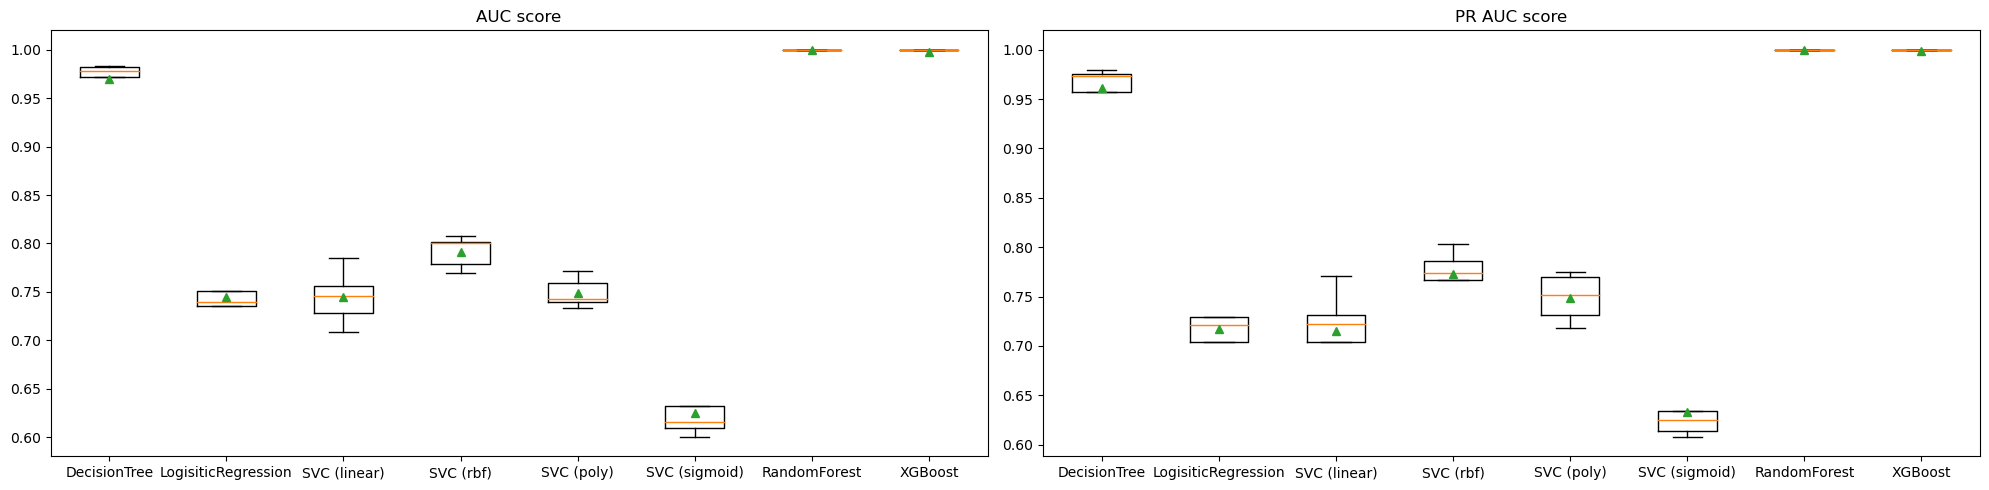

In [14]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Hormis XGBoost tous les résultats sont un peu en dessous de ceux obtenus après SMOTE mais bien meilleurs que ceux obtenus après avoir tuné les hyper-paramètres.

### Undersampling

Une première approche consiste à supprimer aléatoirement des observations de la classe majoritaire dans le jeu d'entraînement.

In [15]:
#Undersampling par Random Undersampling
rus = RandomUnderSampler(random_state=7)
X_res, y_res = rus.fit_resample(X_train, y_train)

print('Distribution après oversampling\n', y_res.value_counts())

Distribution après oversampling
 0    564
1    564
Name: Attrition, dtype: int64


In [16]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.8377133375474083 
PR AUC: 0.7678841787896706 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.7265727263573611 
PR AUC: 0.7125477355913373 

SVC (linear) 
ROC AUC: 0.7377774576821097 
PR AUC: 0.72146144020009 

SVC (rbf) 
ROC AUC: 0.7438964903840775 
PR AUC: 0.746547317884783 

SVC (poly) 
ROC AUC: 0.6950990400859224 
PR AUC: 0.6970191905034671 

SVC (sigmoid) 
ROC AUC: 0.6858584686125998 
PR AUC: 0.6908860986992031 

RandomForest 
ROC AUC: 0.970990288981126 
PR AUC: 0.9763627832242406 

XGBoost 
ROC AUC: 0.9578434937292325 
PR AUC: 0.9567658799907193 



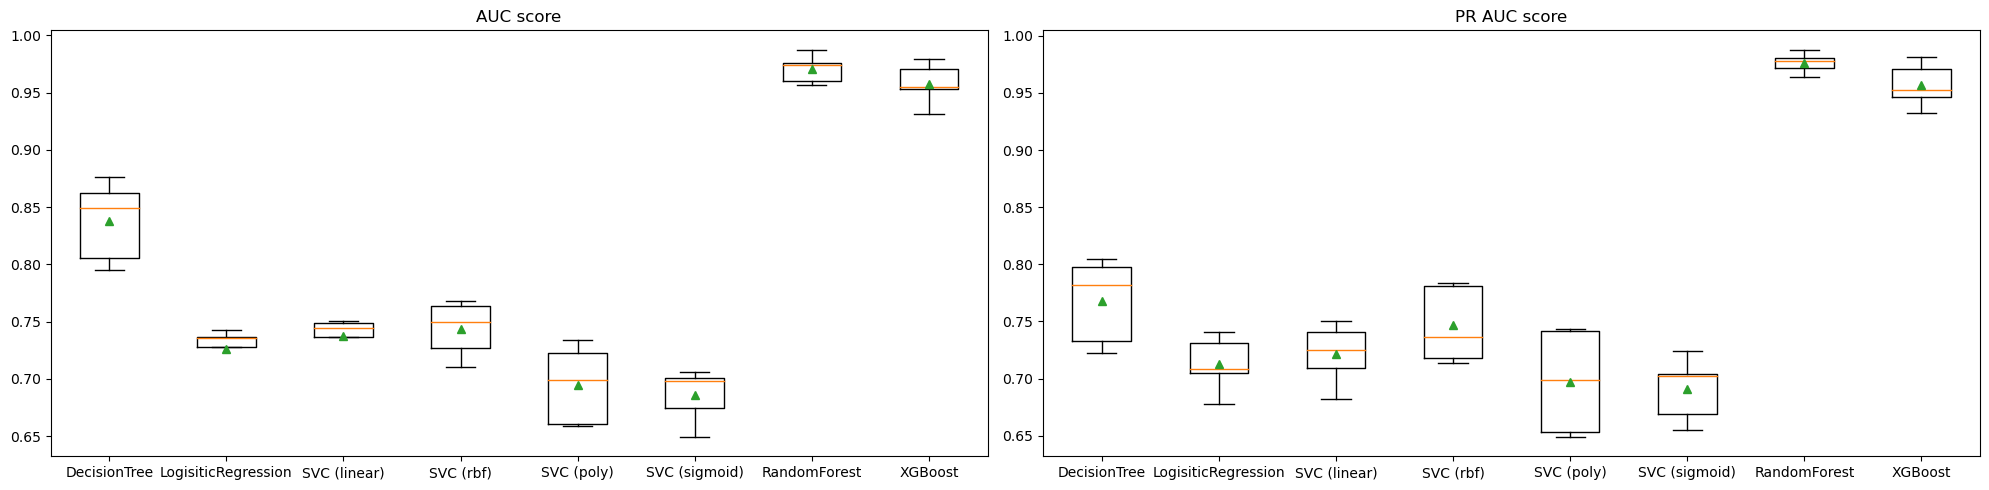

In [17]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Les résultats sont un peu en dessous de ceux obtenus après oversampling et ont également une plus grande variance comme l'indique la représentation en boxplot. Toutefois ces résultats restent meilleurs que ceux obtenus après avoir tuné les hyper-paramètres. Les modèles RandomForest et XGBoost semblent moins risquer l'overfitting.

Une autre approche est celle dite des Tomek Links. Un lien de Tomek est une paire d'observations qui sont plus proches voisins (ayant la plus petite distance dans l'espace des caractéristiques) et qui appartiennent à des classes différentes. Ce sont souvent des exemples mal classés car à la frontière des classes. Les exemples de la classe majoritaire de chaque paire sont supprimés pour faciliter la classification.

In [23]:
#Undersampling avec Tomek Links
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)

print('Distribution après undersampling\n', y_res.value_counts())

Distribution après undersampling
 0    2936
1     564
Name: Attrition, dtype: int64


In [24]:
#Evaluation de la performance de chaque algorithme à partir de l'AUC et de la PR AUC
results_auc = []
results_prauc = []

for key, clf in clfs.items():
    clf_results_auc = cross_validate(clf, X_res, y_res, scoring='roc_auc', cv=5)
    results_auc.append(clf_results_auc['test_score'])
    clf_results_prauc = cross_validate(clf, X_res, y_res, scoring='average_precision', cv=5)
    results_prauc.append(clf_results_prauc['test_score'])
    print(key, 
          "\nROC AUC:", clf_results_auc['test_score'].mean(),
          "\nPR AUC:", clf_results_prauc['test_score'].mean(),
          "\n")

DecisionTree 
ROC AUC: 0.944860438635058 
PR AUC: 0.8448929974929642 



/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisiticRegression 
ROC AUC: 0.7417283418605243 
PR AUC: 0.3966414987399493 

SVC (linear) 
ROC AUC: 0.653786365141124 
PR AUC: 0.2759406669607457 

SVC (rbf) 
ROC AUC: 0.8234034121184273 
PR AUC: 0.5679289140604266 

SVC (poly) 
ROC AUC: 0.8341932473663789 
PR AUC: 0.5285939812728147 

SVC (sigmoid) 
ROC AUC: 0.5808944538118229 
PR AUC: 0.27015356282194813 

RandomForest 
ROC AUC: 0.9918514784348085 
PR AUC: 0.9737150266033824 

XGBoost 
ROC AUC: 0.972781047096548 
PR AUC: 0.9483141980322667 



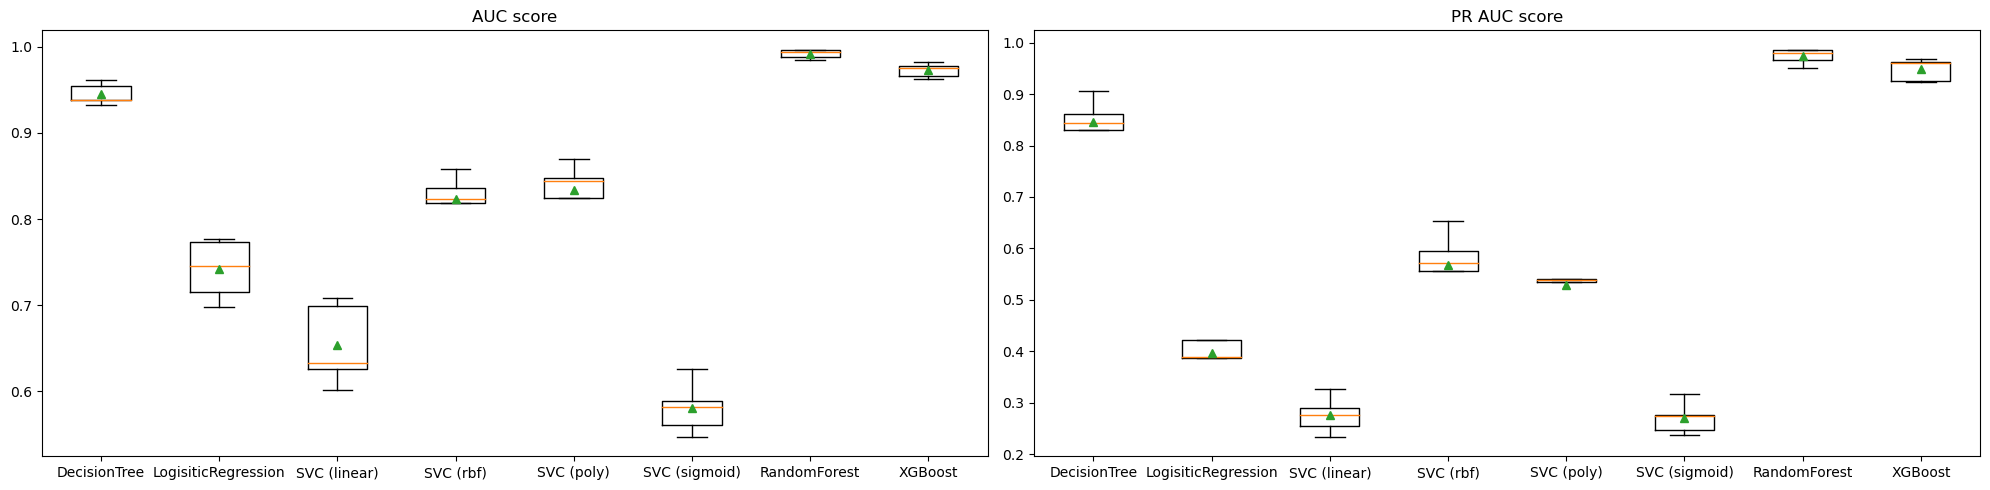

In [25]:
#Comparaison des scores AUC et PR AUC avec un boxplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axs[0].boxplot(results_auc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[1].boxplot(results_prauc, labels=list(clfs.keys()), showmeans=True, showfliers=False)
axs[0].set_title("AUC score")
axs[1].set_title("PR AUC score")
plt.tight_layout()
plt.show()

Le jeu étant déséquilibré après resampling, le PR AUC est un meilleur indicateur des résultats. Comme supposé, grâce à la suppression des liens de Tomek, certains modèles SVM performent mieux qu'avec les autres techniques de resampling. Mais ces résultats n'atteignent pas la performance des modèles ensemblistes.

Globalement les résultats sont moins bons que ceux obtenus après oversampling et ont également une plus grande variance. Certains résultats ne sont pas au dessus de ceux obtenus après avoir tuné les hyper-paramètres. Entre toutes les techniques, les résultats les plus prometteurs sont ceux obtenus par RandomForest et XGBoost avec oversampling ou undersampling avec suppression des liens de Tomeks.

## (b) Pour chaque approche, définissez un modèle performant en recherchant de bons hyper-paramètres via un grid search. Comparer les meilleurs modèles pour chaque approche sur la base de l’AUC (Area Under the Curve).

### Oversampling

#### Oversampling avec SMOTE

In [9]:
#Oversampling avec SMOTE
sm = SMOTE(random_state=7)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [33]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [5,10,15,20,25,30,35,40,46],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'gini', 'max_depth': 15, 'random_state': 7} 
ROC AUC: 0.9795060410949314


In [39]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[0.1,1,10,100],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Meilleure configuration: {'C': 10, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.7762037651183038


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La complexité de calcul étant importante avec les SVM seul les kernels rbf et poly, qui semblaient les plus prometteurs avec SMOTE, sont utilisés.

In [47]:
#Instanciation du modèle SVC avec kernel
clf_svc = SVC()

#Création de la grille de paramètres à tester
param_grid = {'C': [1e-6, 1e-5, 1e-4], 
              'kernel': ['rbf', 'poly'], #'linear', 'rbf', 'poly', 'sigmoid'
              'gamma': ['scale', 'auto', 1, 10, 100],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'C': 1e-05, 'gamma': 1, 'kernel': 'rbf', 'random_state': 7} 
ROC AUC: 0.9996127246389588


In [44]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [50,100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [1,5,10,15,20,25,46],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100, 'random_state': 7} \ROC AUC: 0.9996133757777622


In [46]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [5,10,15,20,46],
              'n_estimators': [100],
              'reg_alpha': [0.01,0.1],
              'reg_lambda': [0.01,0.1],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100, 'random_state': 7, 'reg_alpha': 0.1, 'reg_lambda': 0.1} 
ROC AUC: 0.9984985446311161


#### Oversampling avec ADASYN

In [25]:
#Oversampling avec ADASYN
ada = ADASYN(random_state=7)
X_res, y_res = ada.fit_resample(X_train, y_train)

In [26]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [5,10,15,20,25,30,35,40,46],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'gini', 'max_depth': 20, 'random_state': 7} 
ROC AUC: 0.9695330647916842


In [27]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[0.1,1,10,100],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

Meilleure configuration: {'C': 1, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.7444410733960307


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logis

La complexité de calcul étant importante avec les SVM seul les kernels rbf et linear, qui semblaient les plus prometteurs avec ADASYN, sont utilisés.

In [29]:
#Instanciation du modèle SVC avec kernel
clf_svc = SVC()

#Création de la grille de paramètres à tester
param_grid = {'C': [1e-4, 1e-3, 1e-2], 
              'kernel': ['rbf', 'poly'],
              'gamma': ['scale', 'auto', 1, 10, 100],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'C': 0.001, 'gamma': 1, 'kernel': 'rbf', 'random_state': 7} 
ROC AUC: 0.9993504974980647


In [14]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [50,100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [1,5,10,15,20,25,46],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100, 'random_state': 7} \ROC AUC: 0.9997629919072303


In [18]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [5,10,15,46],
              'n_estimators': [100],
              'reg_alpha': [0.01,0.1],
              'reg_lambda': [0.01,0.1],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'random_state': 7, 'reg_alpha': 0.1, 'reg_lambda': 0.1} 
ROC AUC: 0.9985785250157806


DecisionTree performe moins bien qu'après SMOTE et est plus complexe (profondeur de 20 au lieu de 10).

LogisticRegression performe moins bien et est plus complexe (C=1 au lieu de 10).

SVC performe moins bien mais est moins complexe (C=0.001 au lieu de 0.00001).

RandomForest performe quasiment pareil mais est moins complexe (profondeur de 15 au lieu de 20).

XGBoost performe quasiment pareil mais est moins complexe (profondeur de 10 au lieu de 15).

### Undersampling

#### Undersampling par Random Undersampling

In [30]:
#Undersampling par Random Undersampling
rus = RandomUnderSampler(random_state=7)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [20]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [5,10,15,20,25,30,35,40,46],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 15, 'random_state': 7} 
ROC AUC: 0.8542419979190672


In [22]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[0.001,0.01,0.1,1],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

Meilleure configuration: {'C': 0.1, 'penalty': 'l2', 'random_state': 7, 'solver': 'lbfgs'} 
ROC AUC: 0.7283810959578443


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selec

La complexité de calcul étant importante avec les SVM seul les kernels rbf et poly, qui semblaient les plus prometteurs avec SMOTE, sont utilisés.

In [32]:
#Instanciation du modèle SVC avec kernel
clf_svc = SVC()

#Création de la grille de paramètres à tester
param_grid = {'C': [1e-6, 1e-5, 1e-4], 
              'kernel': ['rbf', 'linear'],
              'gamma': ['scale', 'auto', 1, 10, 100],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'C': 1e-05, 'gamma': 1, 'kernel': 'rbf', 'random_state': 7} 
ROC AUC: 0.9611283745231194


In [34]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [50,100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5,15,20,25,30,35,46],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 100, 'random_state': 7} \ROC AUC: 0.9725374931474665


In [35]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [5,10,15,20,46],
              'n_estimators': [100],
              'reg_alpha': [0.01,0.1],
              'reg_lambda': [0.01,0.1],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'random_state': 7, 'reg_alpha': 0.01, 'reg_lambda': 0.01} 
ROC AUC: 0.9634234138482711


Les résultats sont moins bons et les modèles sont globalement plus complexes qu'après oversampling. En revanche les résultats sont obtenus beaucoup plus rapidement en raison du plus petit nombre d'observations. C'est un critère à prendre en compte.

#### Undersampling avec Tomek Links

In [36]:
#Undersampling avec Tomek Links
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)

In [37]:
#Instanciation du modèle d'arbre de décision
clf_tree = DecisionTreeClassifier()

#Création de la grille de paramètres à tester
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [5,10,15,20,25,30,35,40,46],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_tree, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'entropy', 'max_depth': 15, 'random_state': 7} 
ROC AUC: 0.9464999009398254


In [40]:
#Instanciation du modèle de régression logistique
clf_logreg = LogisticRegression()

#Création de la grille de paramètres à tester
param_grid = {'penalty':['l2', 'l1', 'elasticnet'],
              'C':[100,1000,1e4,1e5],
              'solver': ['lbfgs', 'sag', 'saga'],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_logreg, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/sit

Meilleure configuration: {'C': 1000, 'penalty': 'l2', 'random_state': 7, 'solver': 'sag'} 
ROC AUC: 0.7430670109039098


/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/utilisateur/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logis

La complexité de calcul étant importante avec les SVM seul les kernels rbf et poly, qui semblaient les plus prometteurs avec SMOTE, sont utilisés.

In [45]:
#Instanciation du modèle SVC avec kernel
clf_svc = SVC()

#Création de la grille de paramètres à tester
param_grid = {'C': [1e-6, 1e-5, 1e-4], 
              'kernel': ['rbf', 'poly'],
              'gamma': ['scale', 'auto', 1, 10, 100],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_svc, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'C': 1e-06, 'gamma': 1, 'kernel': 'rbf', 'random_state': 7} 
ROC AUC: 0.9756637640179381


In [42]:
#Instanciation du modèle RandomForest
clf_rf = RandomForestClassifier()

#Création de la grille de paramètres à tester
param_grid = {'n_estimators': [50,100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5,15,20,25,35,40,46],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_rf, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\ROC AUC:", grid.best_score_)

Meilleure configuration: {'criterion': 'gini', 'max_depth': 35, 'n_estimators': 50, 'random_state': 7} \ROC AUC: 0.9921097510266303


In [44]:
#Instanciation du modèle XGBoost
clf_xgb = XGBClassifier()

#Création de la grille de paramètres à tester
param_grid = {'learning_rate': [0.3],
              'max_depth': [5,15,30,35,40,46],
              'n_estimators': [100],
              'reg_alpha': [0.01,0.1],
              'reg_lambda': [0.01,0.1],
              'random_state': [7]}

grid = GridSearchCV(estimator=clf_xgb, 
                    param_grid=param_grid,
                    scoring='roc_auc',
                    return_train_score=True,
                    cv=5)

grid.fit(X_res, y_res)

print("Meilleure configuration:", grid.best_params_, 
      "\nROC AUC:", grid.best_score_)

Meilleure configuration: {'learning_rate': 0.3, 'max_depth': 30, 'n_estimators': 100, 'random_state': 7, 'reg_alpha': 0.01, 'reg_lambda': 0.1} 
ROC AUC: 0.978494056221032


Les résultats sont moins bons et les modèles plus complexes qu'après les techniques d'oversampling ou le random under sampling.

### Meilleure approche et meilleur modèle

In [46]:
#Oversampling avec ADASYN
ada = ADASYN(random_state=7)
X_res, y_res = ada.fit_resample(X_train, y_train)

#Instanciation du meilleur modèle
clf = XGBClassifier(learning_rate=0.3, 
                    max_depth=10, 
                    n_estimators=100,
                    random_state=7,
                    reg_alpha=0.1,
                    reg_lambda=0.1)

clf.fit(X_res, y_res)

#Classification du jeu test
pred = cross_val_predict(clf, X_test, y_test, cv=5)

#Résultats
clf_results = cross_validate(clf, X_test, y_test, scoring='roc_auc', cv=5)
print("\nROC AUC:", clf_results['test_score'].mean())


ROC AUC: 0.854584930763678


In [47]:
#Matrice de confusion
print(confusion_matrix(y_test, pred))

[[716  20]
 [ 72  69]]


In [48]:
#Rapport de classification
print(classification_report(y_test, pred, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       736
           1       0.78      0.49      0.60       141

    accuracy                           0.90       877
   macro avg       0.84      0.73      0.77       877
weighted avg       0.89      0.90      0.89       877



Cette combinaison de sampling et de modèle donne les meilleurs résultats obtenus jusqu'à présent sur ce jeu de données.

Toutefois il y a un peu plus de faux négatifs qu'avec notre modèle RandomForest sans resampling. Un arbitrage devrait être pris en fonction de ce critère. Dans le cas de démissions il vaut peut être mieux privilégier la combinaison prédisant le plus petit nombre de faux négatifs pour éviter une pénurie d'employés.